#Предсказание токсичности соединений

##Введение

Данный проект посвящен предсказанию токсичности соединений с использованием данных о их химических свойствах.

Поставлены следующие задачи:

1. Провести анализ данных.


2. Предобработать данные.

3. Выбрать лучшую моделт и обучить ее на данных. В качестве метрики качества модели необходимо использовать RMSE.

4. Провести валидацию и тестирование лучшей модели.

Изначально не было дано пояснений к данным, в связи с этим сразу перейдем к подготовке и анализу данных.

##Загрузка библиотек и написание собственных функций

In [ ]:
#библиотека для работы с химическими данными
!pip install rdkit

In [ ]:
!pip install phik

In [ ]:
#проверим все установленные библиотеки
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.8.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.6.23.0.

In [ ]:
#загрузим необходимые библиотеки
import warnings
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from phik import phik_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  mean_squared_error,  make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

import shap

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', module='pandas')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
#функция для изучения данных на аномальные значения и попуски
#функция принимает на вход DataFrame, выводит текстовые сообщения на консоль
def anomaly(data):
  #сли передан Series, преобразуем его в DataFrame
  if isinstance(data, pd.Series):
    data = data.to_frame()
  #выводим размер датасета
  print(f'Размер файла:{data.shape}')
  print('-'*100)
  #для вывода всех столбцов создаем цикл
  #выделяем в отдельную переменную названия столбцов
  column_data= data.columns
  #циклом перебираем все значения и выводим данные
  for c in column_data:
    #выводим все уникальные значения
    print(f'Уникальные значения показателя: {c}')
    print(data[c].unique())
    #считаем количество уникальных значений
    print(f'Количество уникальных значений: {data[c].nunique()}')
    #считаем количество всех значений
    print(f'Количество всех значений: {data[c].count()}')
    #считаем количество пропусков
    print(f'Количество пропусков в столбце {c}: {data[c].isna().sum()}')
    print('-'*100)

In [ ]:
#функция для оценки пропусков в данных
#функция принимает на вход DataFrame, выводит текстовые сообщения на консоль
def nan_counts(df):
  #считаем количество пропусков в строке
  nan_counts = df.isna().sum(axis=1)
  #проверяем, какие строки имеют более половины NaN
  half_nan_rows = nan_counts > len(df.columns) / 2
  #количество строк с более чем половиной NaN
  num_half_nan_rows = half_nan_rows.sum()
  #вывод результатов
  print(f"\nОбщее количество строк с более чем половиной NaN: {num_half_nan_rows}")

In [ ]:
#функция для исследовательского анализа количественных данных
#функция принимает на вход DataFrame (количественные данные), выводит графики на консоль
def analisys_num(data):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    #настраиваем построение гистограммы
    axes[0].hist(data.dropna(), bins=20)
    axes[0].set_title('Гистограмма показателя')
    axes[0].set_xlabel('Значения показателя')
    #визуально выводим среднее значение и медиану
    axes[0].axvline(data.median(), color='b', linestyle='dashed', linewidth=2)
    axes[0].axvline(data.mean(), color='r', linestyle='solid', linewidth=2)
    axes[0].legend(['Медиана', 'Среднее', 'Мода'], prop={'size': 6})

    #постройка боксплота для данных
    axes[1].set_title('Боксплот показателя')
    axes[1].boxplot(data.dropna())
    #настройка скрипичной диаграммы
    axes[2].set_title('Скрипичная диаграмма показателя')
    axes[2].violinplot([data.dropna()], vert=False, widths=0.75,
                       showmeans=True, showmedians=True)
    plt.tight_layout()
    plt.show()
    #выводим статистику по показателю
    print('Показатели описательной статистики')
    print(data.describe())
    print(f'Мода в данных по показателю: {data.mode()}')

In [ ]:
#функция для исследовательского анализа качественных данных с использованием круговой диаграммы
#функция принимает данные и считает их количество внутри каждого уникального значения,
#после выводит круговой график
#функция принимает на вход DataFrame, выводит графики на консоль
def analisys_cat_pie(data, labels=None):
    if labels is not None:
      data = data.map(labels)

    data.value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(5, 5))
    plt.title('Круговая диаграмма показателя', size=10)
    plt.show()

In [ ]:
#функция для исследовательского анализа качевтенных данных с использованием столбчатой диаграммы
#функция принимает данные и считает их количество внутри каждого уникального значения,
#после выводит столбчатую диаграмму
#функция принимает на вход DataFrame, выводит графики на консоль
def analisys_cat_plot(data):
    data.value_counts(ascending=True).plot(kind='bar', alpha=0.8)
    plt.title('Столбчатая диаграмма', size=15)
    plt.xlabel('Количество', size=12)
    plt.ylabel('Значения', size=12)
    plt.show()

In [ ]:
#функция для вывода графика Lmplot
#функция принимает датасет и названия столбцов, по которым надо построить график
#функция принимает на вход DataFrame, выводит графики сообщения на консоль
def grafic(data, x, y):
    sns.lmplot(x=x, y=y, data=data)
    plt.title(f'Зависимость показателя {y} от показателя {x}', size=10)
    plt.xlabel(f'Показатель {x}', size=8)
    plt.ylabel(f'Показатель {y}', size=8)
    plt.show()

## Загрузка и первичный анализ данных

In [ ]:
! gdown 1TEpKQLY1jNgJ11qhaI9Ftsntdlpe1lmT

Downloading...
From: https://drive.google.com/uc?id=1TEpKQLY1jNgJ11qhaI9Ftsntdlpe1lmT
To: /content/test_only_smiles.csv
100% 10.1k/10.1k [00:00<00:00, 16.6MB/s]


In [ ]:
! gdown 14tZtDyg0ijnTGhwlsjl05Y2KhOqdUMvb

Downloading...
From: https://drive.google.com/uc?id=14tZtDyg0ijnTGhwlsjl05Y2KhOqdUMvb
To: /content/train.csv
100% 29.9k/29.9k [00:00<00:00, 36.5MB/s]


In [ ]:
test_only_smiles = pd.read_csv('/content/test_only_smiles.csv')

In [ ]:
test_only_smiles.head(5)

,Unnamed: 0,SMILES
0,0,CC(O)CCO
1,1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1
2,2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...
3,3,C=CC(=O)NCNC(=O)C=C
4,4,CC1=CC(=CC=C1)[N+]([O-])=O


In [ ]:
test_only_smiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  253 non-null    int64 
 1   SMILES      253 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB


In [ ]:
train = pd.read_csv('/content/train.csv')

In [ ]:
train.head(10)

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2
5,CCC(C)(C)C1=CC=C(O)C=C1,91.2
6,CCCCOC(=O)[C@@H](C)OC1=CC=C(OC2=C(F)C=C(C=C2)C...,51.1
7,O[C@@H]1[C@H](CC2=CC=CC(=C2)C(O)=O)COC3=C1C=C(...,64.6
8,OC1=C(CC2=C(O)C=CC=C2)C=CC=C1,100.9
9,CC(C)(C)C1=CC=C(S)C=C1,37.9


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    759 non-null    object 
 1   activity  759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


Вывод: в данных представлены в виде формул и чисел. Проведен анализ данных.

## Предобработка данных

In [ ]:
anomaly(test_only_smiles)

Размер файла:(253, 2)
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: Unnamed: 0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 20

In [ ]:
nan_counts(test_only_smiles)


Общее количество строк с более чем половиной NaN: 0


Датасет не содержит явных аномалий и пропусков. Столбец Unnamed: 0 не несет никакой информации и скорее всего является дублером индекса. Поэтому удалим его.

In [ ]:
test_only_smiles = test_only_smiles.drop(columns=['Unnamed: 0'])

In [ ]:
anomaly(train)

Размер файла:(759, 2)
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: SMILES
['OCC=C' 'CO/N=C(/C(=O)OC)\\C1=C(COC2=C(C)C=CC=C2)C=CC=C1'
 'COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1' 'CCCCC(CC)C(O)=O'
 'COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F)(F)F'
 'CCC(C)(C)C1=CC=C(O)C=C1'
 'CCCCOC(=O)[C@@H](C)OC1=CC=C(OC2=C(F)C=C(C=C2)C#N)C=C1'
 'O[C@@H]1[C@H](CC2=CC=CC(=C2)C(O)=O)COC3=C1C=C(OCC4=NC5=C(S4)C=CC(F)=C5)C=C3'
 'OC1=C(CC2=C(O)C=CC=C2)C=CC=C1' 'CC(C)(C)C1=CC=C(S)C=C1'
 'CCCCCCCCCC1=CC=C(OCCO)C=C1' 'CCC[Si](OC)(OC)OC' 'CCCC=NO'
 'CCCCN(CCCC)SN(C)C(=O)OC1=C2OC(C)(C)CC2=CC=C1'
 'CCC1=NC(N)=NC(N)=C1C2=CC=C(Cl)C=C2' 'C[Sn](C)(Cl)Cl' 'CCCCCCCCSCCO'
 'CCCCCCCCCCCC(=O)OCC(C)OC(=O)CCCCC(=O)O' '[P+](OCC)(OCC)=O'
 'CC(C)C1=CC=CC(O)=C1' 'COC1=CC(C=CC)=CC=C1O'
 'ClC1=CC=C(C=C1)C2=C(NC(=O)C3=C(Cl)N=CC=C3)C=CC=C2'
 'CC(C)(C1=CC(Br)=C(O)C(Br)=C1)C2=CC(Br)=C(O)C(Br)=C2'
 'CC(=O)C1=CC=C(O)C=C1' 'CC(CCO)CCC=C(C)C'
 'CN(C)C1=CC=C

In [ ]:
nan_counts(train)


Общее количество строк с более чем половиной NaN: 0


In [ ]:
train.duplicated().sum()

np.int64(0)

В активности обнаружены отрицательные значения. После фактчекинга и болнн подробного изучения метода QSAR было обнаружено, что активность может принимать отрицательные значения. Данный метод может быть откалиброван по определенному референсу, в связи с чем шкала может принимать отрицательные значения. Т к более никакой информации о датасетах не было передано, принято решение на данный момент оставить отрицательные значения. Пропусков и других аномалий обнаружено не было, в датасете train нет явнфх дубликатов.

**Вывод**

На этапе преподготовки в данных не обаружены пропуски или явные аномалии.

##Исследовательский анализ

В столбцах SMILES прописаны формулы по одноименному принципу.

SMILES – Упрощенная Молекулярная Система Ввода Входной Строки (Simplified
Molecular Input Line Entry System). Это химическая система представления, используемая для представления молекулярных структур линейной строкой символов. Представление SMILES представляет молекулярную структуру как двумерное
изображение.

Для изучения данных создадим дополнительные столбцы, содержащие информацию о функциональных группах: спирты, алкилы, фенол, карбоновые кислоты, эфиры, амиды, аминогруппы, альдегиды, кетоны, тиоэфиры, цианогруппы, изоционады, меркаптаны, галогены, соли. Функциональные группы оказывают значительное влияние на токсичность химических соединений, так как они определяют физикохимические свойства молекул, такие как липофильность, способность проникать сквозь мембраны клеток, метаболизм, устойчивость и взаимодействие с биологическими мишенями организма. Так же расчитаем молекулярную массу каждого вещества.

Для анализа химических данных используем инструменты библиотеки rdkit.

Подробную информацию изучила по ссылкам:

 https://education.molssi.org/python-data-science-chemistry/rdkit_descriptors/rdkit.html

 https://archive.epa.gov/med/med_archive_03/web/html/smiles.html


In [ ]:
smart_patterns = {
    'alcohols': '[OX2H]',                 # спирты (OH-группа)
    'phenol': 'c-[OX2H]',                 # фенол (OH-группа в ароматическом кольце)
    'carboxylic_acids': '[CX3](=O)[OX1H0]',  # карбоновая кислота (COOH)
    'esters': '[CX3](=O)-[OX2]-[#6]',    # сложный эфир (COOR)
    'amides': '[NX3,CX3](=O)-[#6]',      # амиды (CONH)
    'amines': '[NX3,NX4]',                # первичный, вторичный или третичный амин
    'aldehydes': '[CX3H1](=O)',          # альдегиды (CHO)
    'ketones': '[#6][CX3](=O)[#6]',      # кетоны (RCOR')
    'thioethers': '[SX2]',                # тиоэфиры (RS)
    'cyanogroups': '[#6]#[#7]',          # цианогруппы (CN)
    'isocyanates': '[-,#6]~[NX2D1](=O)=O',  # изоцианаты (NCO)
    'mercaptans': '[SX1H]',               # меркаптаны (SH)
    'halogens': '[F,Cl,Br,I]',           # галогены (F, Cl, Br, I)
    'salts': '*~[+,-]',                   # соли (наличие заряженного атома)
}

# Функция для поиска функциональных групп
def find_functional_groups(smiles):
    #преобразуем строку SMILES в объект mol
    mol = Chem.MolFromSmiles(smiles)
    #создаем пустой словарь
    functional_groups = {}

    # Проверяем наличие каждой функциональной группы
    for name, smart_pattern in smart_patterns.items():
        #проверяем методом HasSubstructMatch совпадение частей молекул с SMART-запросов
        match = mol.HasSubstructMatch(Chem.MolFromSmarts(smart_pattern))
        functional_groups[name] = match

    return functional_groups

In [ ]:
#переводим словарь в датафрейм
groups_df = test_only_smiles['SMILES'].apply(find_functional_groups)

# преобразование Series объектов dict в dataframe
groups_df = pd.json_normalize(groups_df.values)

# объединение данных
test_only_smiles_gr = pd.concat([test_only_smiles.reset_index(drop=True), groups_df], axis=1)

In [ ]:
test_only_smiles_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SMILES            253 non-null    object
 1   alcohols          253 non-null    bool  
 2   phenol            253 non-null    bool  
 3   carboxylic_acids  253 non-null    bool  
 4   esters            253 non-null    bool  
 5   amides            253 non-null    bool  
 6   amines            253 non-null    bool  
 7   aldehydes         253 non-null    bool  
 8   ketones           253 non-null    bool  
 9   thioethers        253 non-null    bool  
 10  cyanogroups       253 non-null    bool  
 11  isocyanates       253 non-null    bool  
 12  mercaptans        253 non-null    bool  
 13  halogens          253 non-null    bool  
 14  salts             253 non-null    bool  
dtypes: bool(14), object(1)
memory usage: 5.6+ KB


In [ ]:
bool_columns = test_only_smiles_gr.select_dtypes(include=['bool']).columns
test_only_smiles_gr['group_count'] = test_only_smiles_gr[bool_columns].sum(axis=1)

In [ ]:
test_only_smiles_gr.head(5)

,SMILES,alcohols,phenol,carboxylic_acids,esters,amides,amines,aldehydes,ketones,thioethers,cyanogroups,isocyanates,mercaptans,halogens,salts,group_count
0,CC(O)CCO,True,False,False,False,False,False,False,False,False,False,False,False,False,False,1
1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1,False,False,False,True,True,False,False,False,False,False,False,False,True,False,3
2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1
3,C=CC(=O)NCNC(=O)C=C,False,False,False,False,True,True,False,False,False,False,False,False,False,False,2
4,CC1=CC(=CC=C1)[N+]([O-])=O,False,False,False,False,True,True,False,False,False,False,False,False,False,True,3


In [ ]:
#переводим словарь в датафрейм
groups_df_tr = train['SMILES'].apply(find_functional_groups)

# преобразование Series объектов dict в dataframe
groups_df_tr = pd.json_normalize(groups_df_tr.values)

# объединение данных
train_gr = pd.concat([train.reset_index(drop=True), groups_df_tr], axis=1)

In [ ]:
bool_columns_gr = train_gr.select_dtypes(include=['bool']).columns
train_gr['group_count'] = train_gr[bool_columns].sum(axis=1)

In [ ]:
bool_columns_gr = train_gr.select_dtypes(include=['bool']).columns
train_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SMILES            759 non-null    object 
 1   activity          759 non-null    float64
 2   alcohols          759 non-null    bool   
 3   phenol            759 non-null    bool   
 4   carboxylic_acids  759 non-null    bool   
 5   esters            759 non-null    bool   
 6   amides            759 non-null    bool   
 7   amines            759 non-null    bool   
 8   aldehydes         759 non-null    bool   
 9   ketones           759 non-null    bool   
 10  thioethers        759 non-null    bool   
 11  cyanogroups       759 non-null    bool   
 12  isocyanates       759 non-null    bool   
 13  mercaptans        759 non-null    bool   
 14  halogens          759 non-null    bool   
 15  salts             759 non-null    bool   
 16  group_count       759 non-null    int64  
dt

In [ ]:
train_gr.head(5)

,SMILES,activity,alcohols,phenol,carboxylic_acids,esters,amides,amines,aldehydes,ketones,thioethers,cyanogroups,isocyanates,mercaptans,halogens,salts,group_count
0,OCC=C,5.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,1
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,2
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4,False,False,False,True,False,True,False,False,False,False,False,False,False,False,2
3,CCCCC(CC)C(O)=O,-8.2,True,False,False,False,True,False,False,False,False,False,False,False,False,False,2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2,False,False,False,True,True,False,False,False,True,False,False,False,True,False,4


In [ ]:
def calculate_molecular_mass(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError('Некорректное представление SMILES')
    return round(Chem.rdMolDescriptors.CalcExactMolWt(mol), 2)

In [ ]:
test_only_smiles_gr['molar_mass'] = test_only_smiles_gr['SMILES'].apply(calculate_molecular_mass)

In [ ]:
test_only_smiles_gr.head(5)

,SMILES,alcohols,phenol,carboxylic_acids,esters,amides,amines,aldehydes,ketones,thioethers,cyanogroups,isocyanates,mercaptans,halogens,salts,group_count,molar_mass
0,CC(O)CCO,True,False,False,False,False,False,False,False,False,False,False,False,False,False,1,90.07
1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1,False,False,False,True,True,False,False,False,False,False,False,False,True,False,3,320.06
2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1,458.08
3,C=CC(=O)NCNC(=O)C=C,False,False,False,False,True,True,False,False,False,False,False,False,False,False,2,154.07
4,CC1=CC(=CC=C1)[N+]([O-])=O,False,False,False,False,True,True,False,False,False,False,False,False,False,True,3,137.05


In [ ]:
train_gr['molar_mass'] = train_gr['SMILES'].apply(calculate_molecular_mass)

Как видно, более информативным является датасет train_gr, основные выводы будем делать по нему. Но предварительно изучим test_only_smiles_g.

In [ ]:
test_only_smiles_gr.columns

Index(['SMILES', 'alcohols', 'phenol', 'carboxylic_acids', 'esters', 'amides',
       'amines', 'aldehydes', 'ketones', 'thioethers', 'cyanogroups',
       'isocyanates', 'mercaptans', 'halogens', 'salts', 'group_count',
       'molar_mass'],
      dtype='object')

Исследовательский анализ показателя alcohols


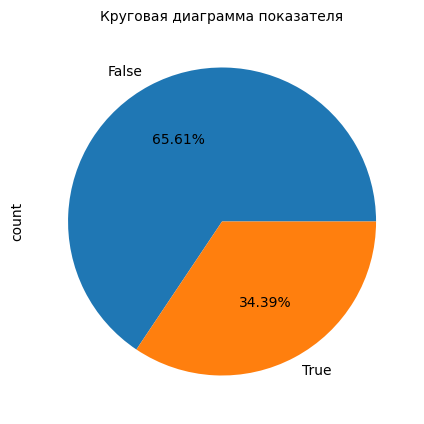

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя phenol


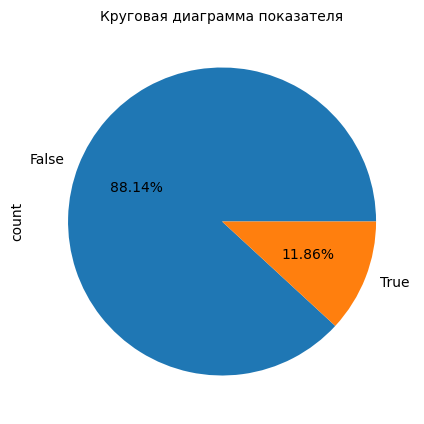

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя carboxylic_acids


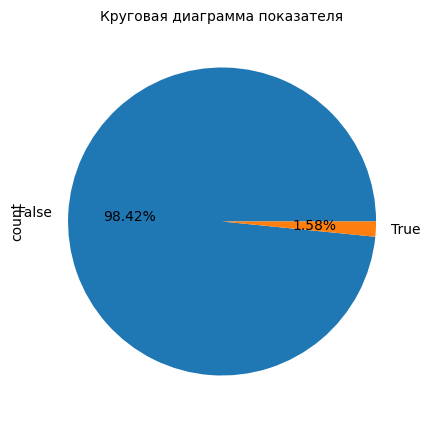

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя esters


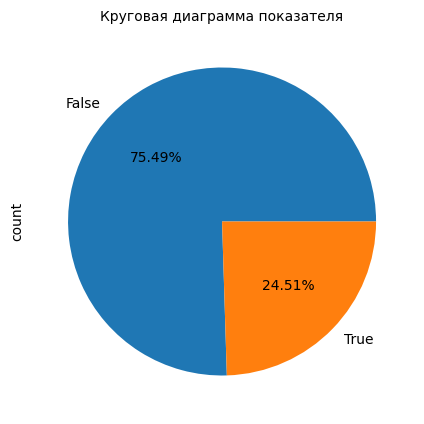

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя amides


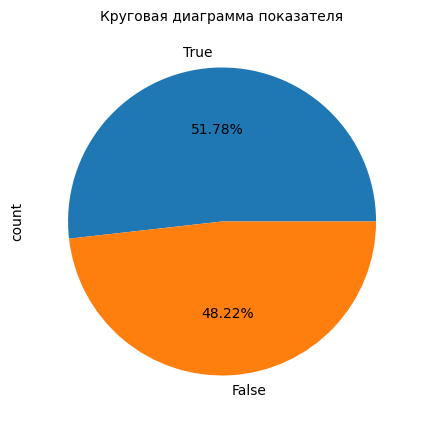

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя amines


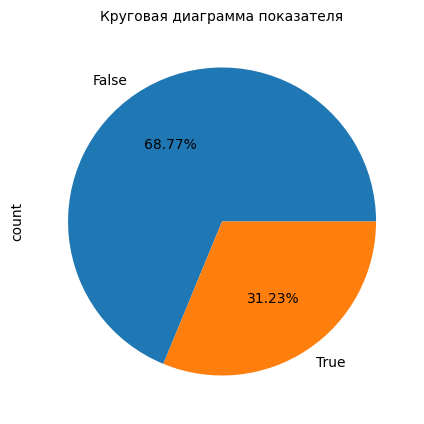

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя aldehydes


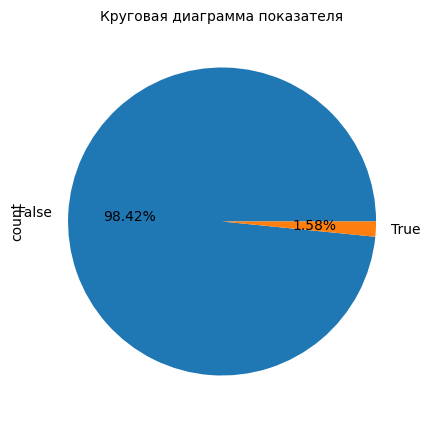

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя ketones


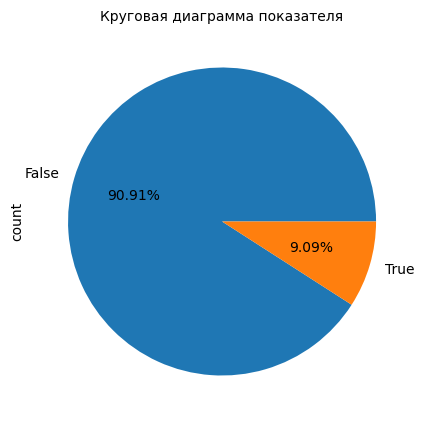

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя thioethers


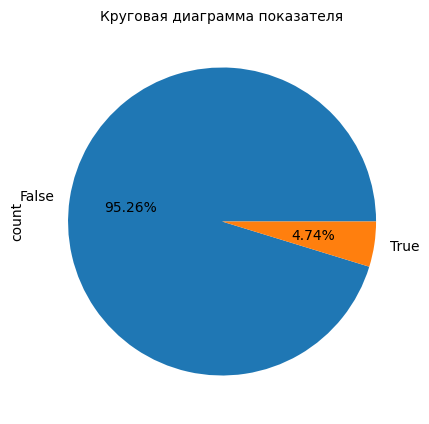

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя cyanogroups


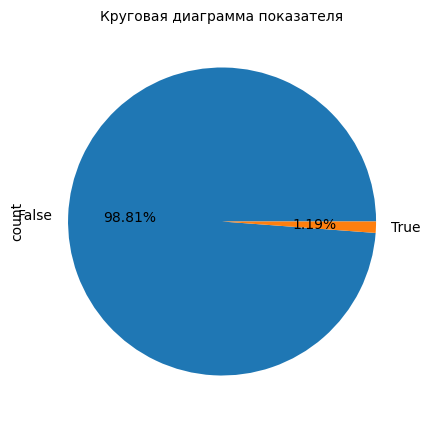

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя isocyanates


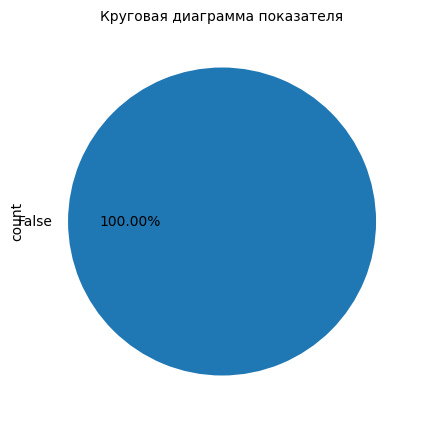

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя mercaptans


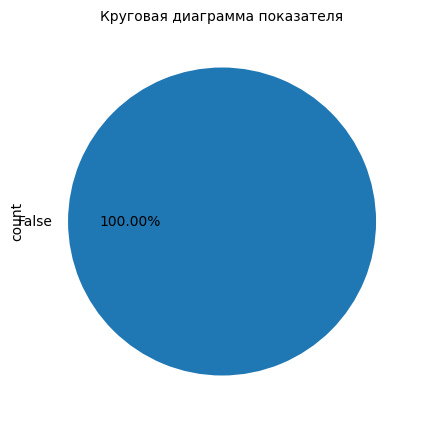

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя halogens


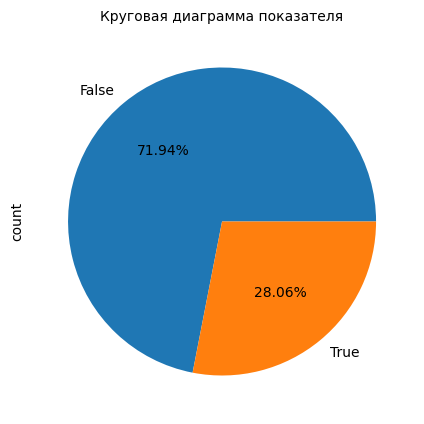

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя salts


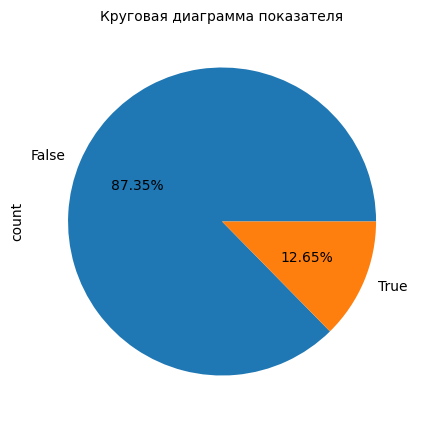

----------------------------------------------------------------------------------------------------


In [ ]:
col_test_only = ['alcohols', 'phenol', 'carboxylic_acids', 'esters', 'amides',
                 'amines', 'aldehydes', 'ketones', 'thioethers', 'cyanogroups',
                 'isocyanates', 'mercaptans', 'halogens', 'salts']
for col in col_test_only:
    print(f'Исследовательский анализ показателя {col}')
    analisys_cat_pie(test_only_smiles_gr[col])
    print('-'*100)

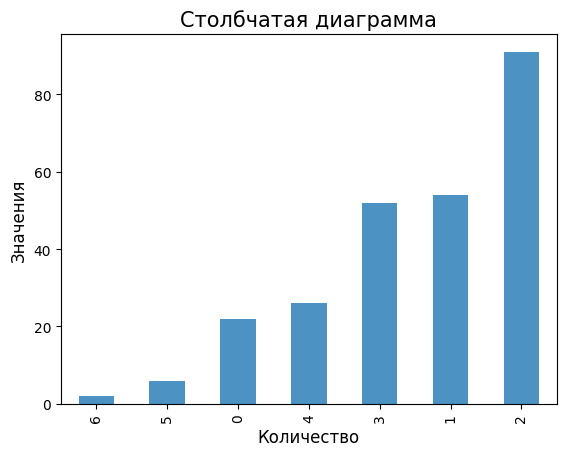

In [ ]:
analisys_cat_plot(test_only_smiles_gr['group_count'])

Как видно из графиков самые распространенные функциональными группами являются гидроксигруппа и амиды. В датасете нет веществ с меркаптанами, изоцианатами. Изучим train и возможно удалим данный показатель из датасета. В датасете представлены вещества в большей части с 2 функциональными группами. Но есть вещества с 5 и 6 функциональными группами.

Изучим второй датасет.

Исследовательский анализ показателя alcohols


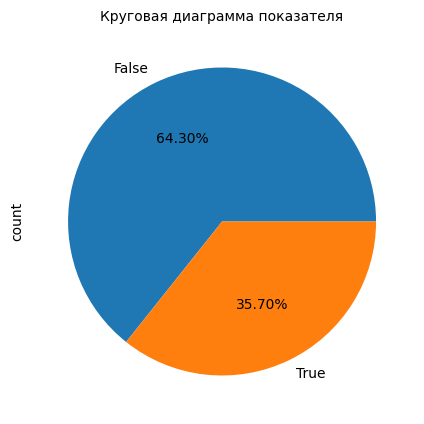

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя phenol


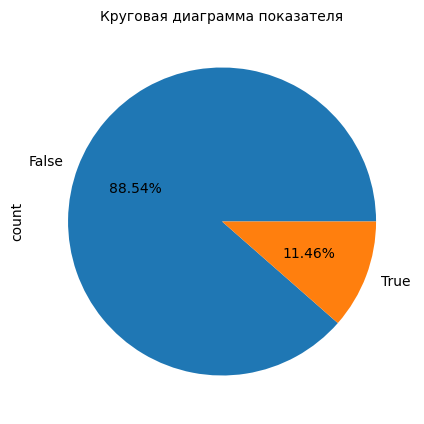

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя carboxylic_acids


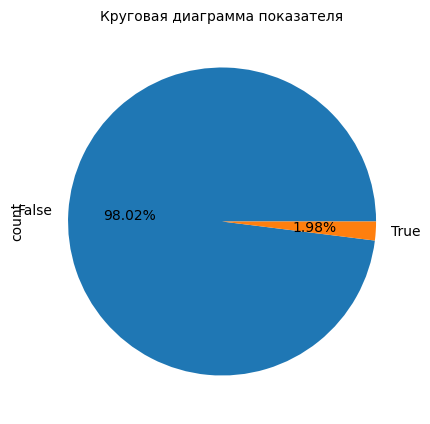

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя esters


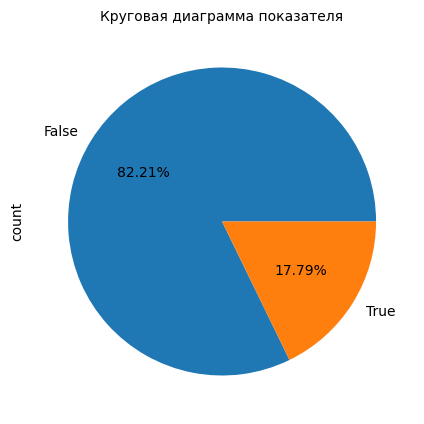

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя amides


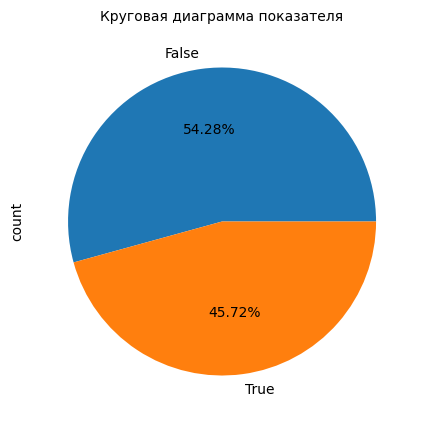

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя amines


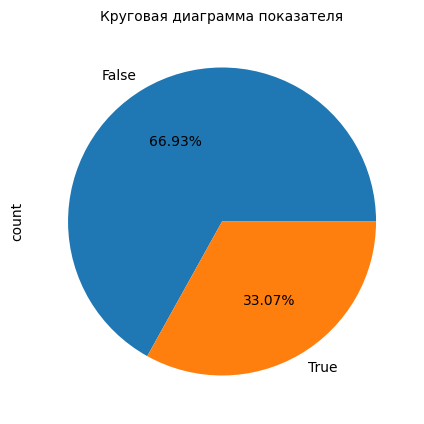

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя aldehydes


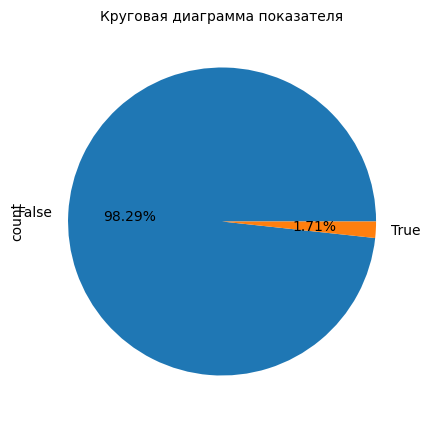

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя ketones


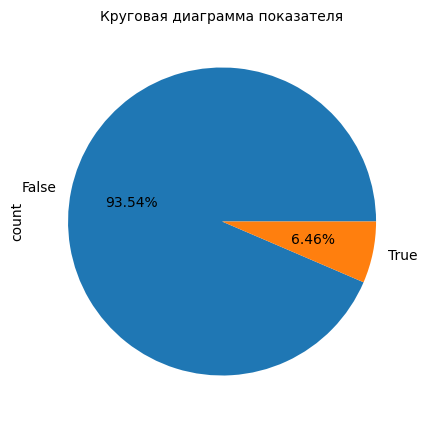

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя thioethers


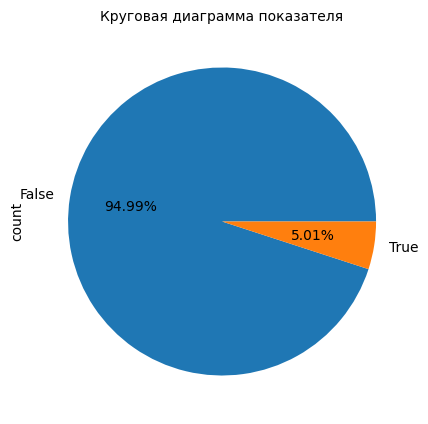

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя cyanogroups


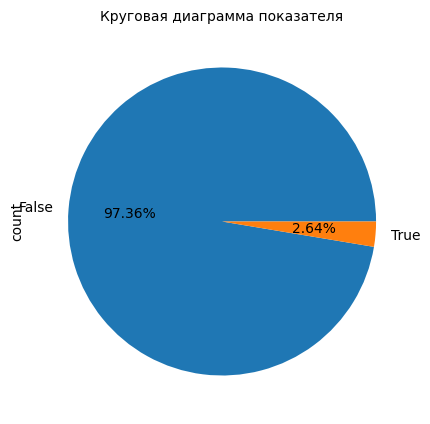

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя isocyanates


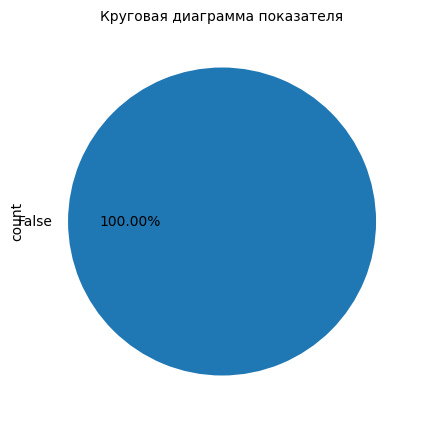

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя mercaptans


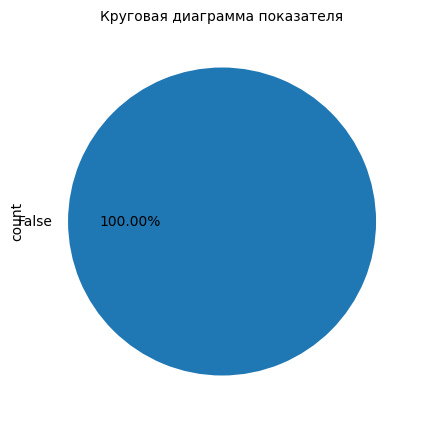

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя halogens


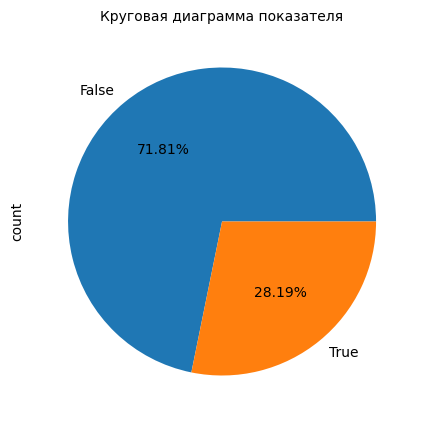

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя salts


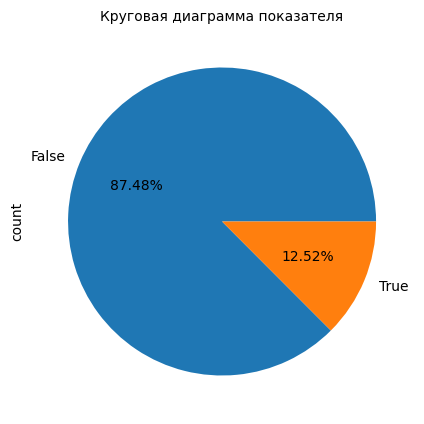

----------------------------------------------------------------------------------------------------


In [ ]:
for col in col_test_only:
    print(f'Исследовательский анализ показателя {col}')
    analisys_cat_pie(train_gr[col])
    print('-'*100)

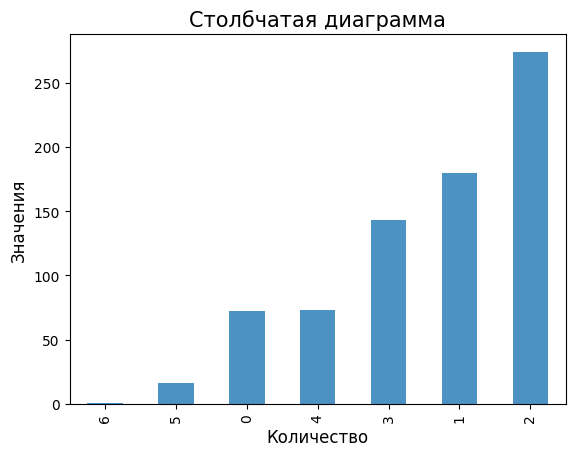

In [ ]:
analisys_cat_plot(train_gr['group_count'])

Исследовательский анализ показателя activity


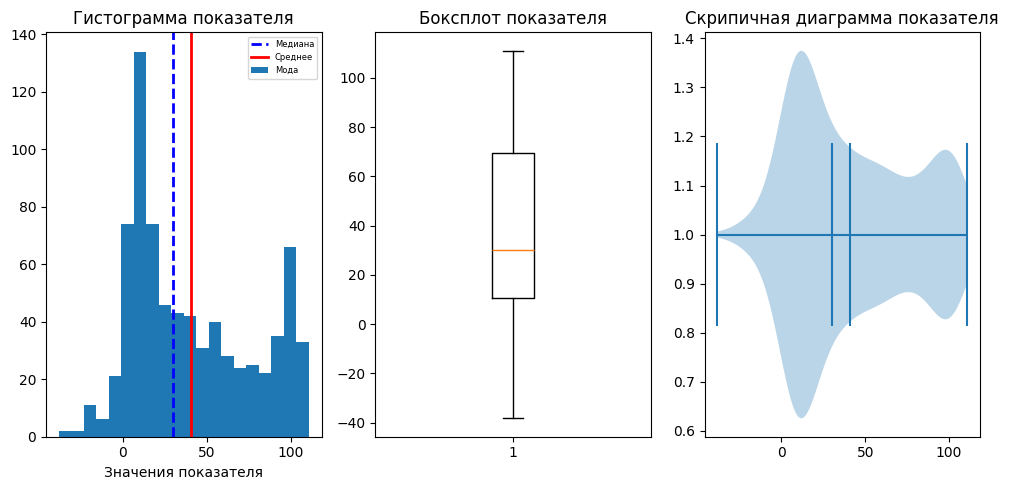

Показатели описательной статистики
count    759.000000
mean      40.691304
std       36.150662
min      -38.300000
25%       10.750000
50%       30.100000
75%       69.550000
max      111.000000
Name: activity, dtype: float64
Мода в данных по показателю: 0    13.4
Name: activity, dtype: float64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя molar_mass


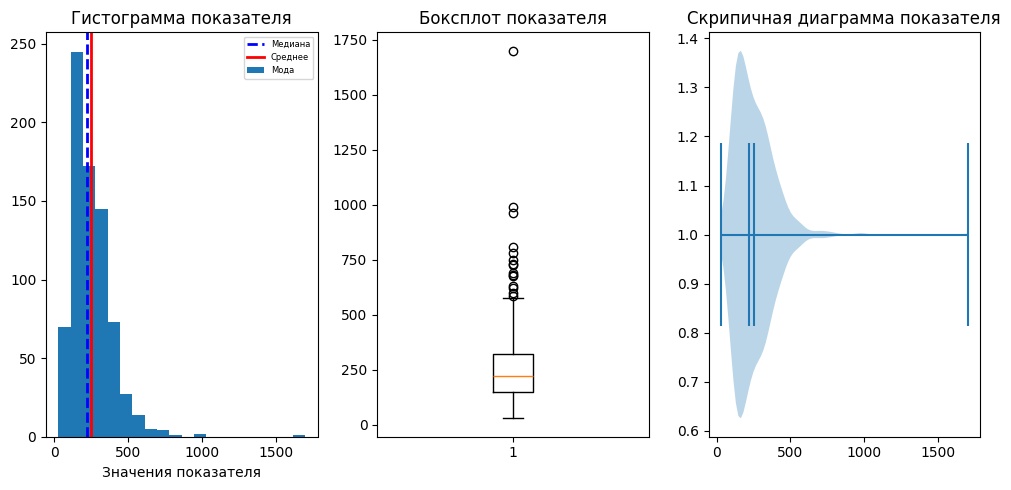

Показатели описательной статистики
count     759.000000
mean      253.469341
std       140.761061
min        30.010000
25%       150.580000
50%       222.200000
75%       324.550000
max      1700.170000
Name: molar_mass, dtype: float64
Мода в данных по показателю: 0    154.14
Name: molar_mass, dtype: float64
----------------------------------------------------------------------------------------------------


In [ ]:
num_column = ['activity', 'molar_mass']

for col in num_column:
    print(f'Исследовательский анализ показателя {col}')
    analisys_num(train_gr[col])
    print('-'*100)

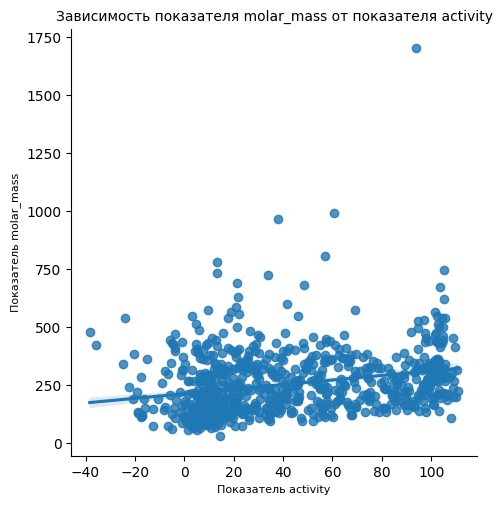

In [ ]:
grafic(train_gr, 'activity', 'molar_mass')

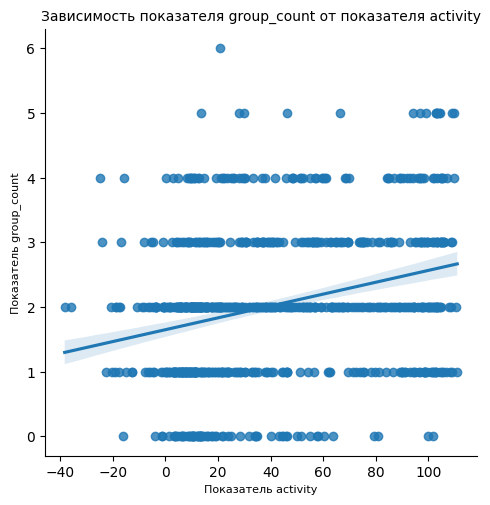

In [ ]:
grafic(train_gr, 'activity', 'group_count')

В обоих датасетах нет веществ с меркаптанами, изоцианатами. Так же наблюдается что в датасете преобладают вещесвта с содержанием гидроксигруппы, амидов, аминов и галогенов. Распеределение активности внутри датасета распределено не нормально, но без выбросов. Данные имеют два пика на активности равной 0 и 13.4. Зависимость активности от количесвта групп не наблюдается. По молекулярной массе наблюдается один выброс по массе, но распределение близко к нормальному и наблюдается зависимость активности от молекулярной массы.

Удалим столбцы с функциональными группами меркаптаном и изоцианатом до построения матрицы с корреляцией.


In [ ]:
train_gr = train_gr.drop(columns = ['isocyanates', 'mercaptans'])

In [ ]:
test_only_smiles_gr = test_only_smiles_gr.drop(columns = ['isocyanates', 'mercaptans'])

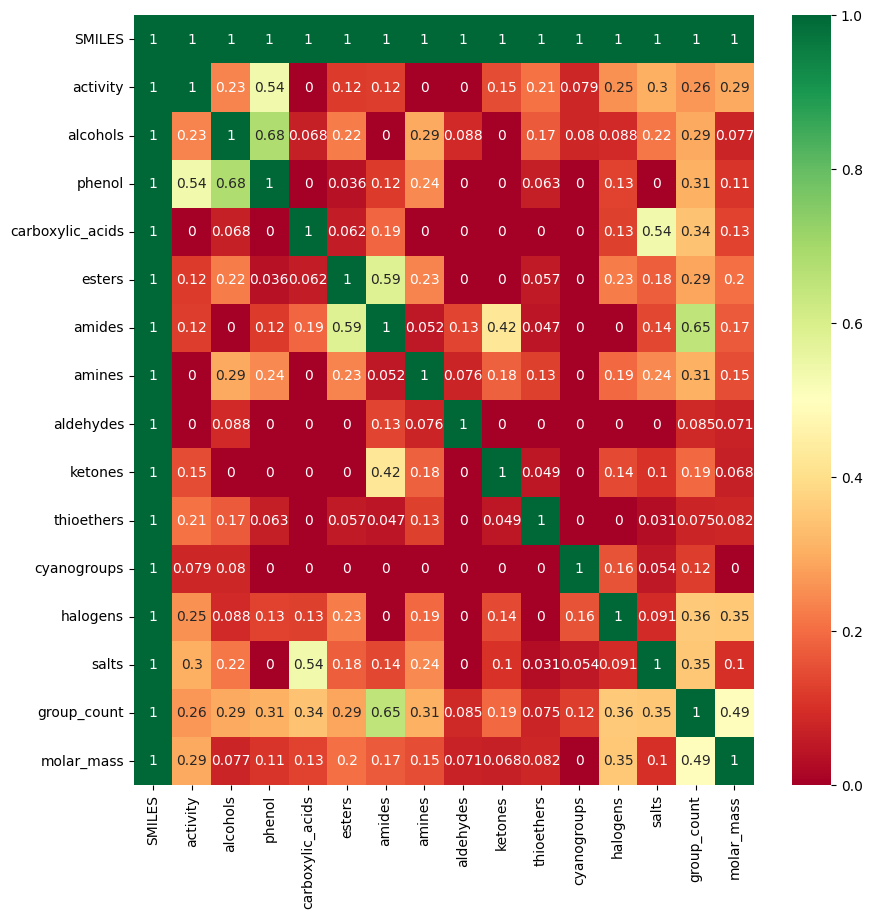

CPU times: user 1.77 s, sys: 53.6 ms, total: 1.82 s
Wall time: 8.97 s


In [ ]:
%%time
corr_matrix_df = train_gr.phik_matrix(interval_cols= ['activity', 'group_count', 'molar_mass'])
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix_df, annot=True, cmap='RdYlGn')
plt.show()

Функциональные группы по отдельности не вносят влияния на активность. Наблюдается слабая связь есть между активностью и наличием галогенов, гидроксигрупп, кетонов и цианогрупп в соединении. Вероятно на активность влияют определенные комбинации функциональных групп. Но наблюдается средняя корреляция между активностью и молекулярной массой.

##Предподговка данных

SMILES – это форма записи молекулы текстом. Модели не понимают текст (если мы не говорим о специальных моделях), поэтому текст нужно превратить в числа. Один из способов превратить молекулы в числа – это fingerprints.

Так же необходимо будет закодировать столбцы с функциональными группами и номрализовать столбцы  с молекулярной массой.

In [ ]:
def smiles_to_fp(smiles):
    '''Convert SMILES to Morgan fingerprints'''
    return np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024) for s in smiles])

In [ ]:
X = train_gr.drop('activity', axis = 1)
y_train = train_gr['activity']

In [ ]:
train_smiles = smiles_to_fp(X['SMILES'])
train_smiles = pd.DataFrame(train_smiles)
train_smiles.columns = [f'SMILES_{i}' for i in range(train_smiles.shape[1])]

[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerator
[12:39:02] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
test_smiles = smiles_to_fp(test_only_smiles_gr['SMILES'])
test_smiles = pd.DataFrame(test_smiles)
test_smiles.columns = [f'SMILES_{i}' for i in range(test_smiles.shape[1])]

[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerator
[12:39:04] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

In [ ]:
test_only_smiles_gr[bool_cols] = test_only_smiles_gr[bool_cols].astype(int)

In [ ]:
scaler = StandardScaler()

num_columns = ['molar_mass']

X_train_scaled = scaler.fit_transform(X[num_columns])
X_test_scaled = scaler.transform(test_only_smiles_gr[num_columns])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

In [ ]:
X_train = pd.concat([pd.DataFrame(train_smiles), X[bool_cols], X_train_scaled], axis=1)
X_test = pd.concat([pd.DataFrame(test_smiles), test_only_smiles_gr[bool_cols], X_test_scaled], axis=1)

##Обучение модели

После предподготовки данных приступаем к обучению модели.

Задачи:

1. Подобрать и отвалидировать лучшую модель с опитмальными гиперпаратметрами

2. Протестировать модель

###Подбор модели для решения **задачи**

Сначала попробуем использовать просую линейную регрессию для поставленной цели прогнозирования токсичности.

In [ ]:
RANDOM_STATE = 42

In [ ]:
#так как в стандартных метриках нет RMSE, то создадим его вручную
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_neg_scorer = make_scorer(rmse_scorer, greater_is_better=False)

In [ ]:
%%time
model_lr = LinearRegression()

score_lr = cross_val_score(model_lr, X=X_train, y=y_train, cv=5, scoring=rmse_neg_scorer)

CPU times: user 4.36 s, sys: 71 ms, total: 4.43 s
Wall time: 4.76 s


In [ ]:
rmse_lr = round(np.mean(-score_lr), 2)
print('RMSE на кросс-валидационных данных = ', rmse_lr)

RMSE на кросс-валидационных данных =  83.32


Обучим модель линейной регересси типа ElasticNet (добавление регуляризацонного члена, который сочетает Lasso и Ridge)

In [ ]:
%%time
regr = ElasticNet(random_state=RANDOM_STATE)

score_regr = cross_val_score(regr, X_train, y_train, cv=5, scoring=rmse_neg_scorer)

CPU times: user 397 ms, sys: 29.8 ms, total: 426 ms
Wall time: 342 ms


In [ ]:
rmse_reqr = round(np.mean(-score_regr), 2)
print('RMSE на кросс-валидационных данных = ', rmse_reqr)

RMSE на кросс-валидационных данных =  31.54


Подберем гиперпараметры и обучим более сложные модели: случайный лес, дерево решений и SVR.

In [ ]:
forest = RandomForestRegressor()

In [ ]:
param_grid_forest = {'n_estimators': [10, 30, 50, 70, 100],
                     'max_depth': range(2, 15),
                     'min_samples_split': range(2, 10),
                     'random_state': [RANDOM_STATE]}

In [ ]:
%%time
grid_search_forest = GridSearchCV(forest,
                                  param_grid_forest,
                                  cv=5,
                                  scoring = rmse_neg_scorer,
                                  n_jobs=-1)

grid_search_forest.fit(X_train, y_train)
rmse_forest = round(-grid_search_forest.best_score_, 2)
print('Параметры лучшей модели:\n',grid_search_forest.best_params_)
print('Метрика RMSE лучшей модели:\n', rmse_forest)

In [ ]:
trmodel = DecisionTreeRegressor()

In [ ]:
param_grid_tr = [{'max_depth': range(2, 20),
                  'max_features': range(2, 20),
                  'max_leaf_nodes': range(2, 20),
                  'random_state':[RANDOM_STATE]}]

In [ ]:
%%time
grid_search_tr = GridSearchCV(trmodel,
                              param_grid_tr,
                              cv=5,
                              scoring=rmse_neg_scorer,
                              n_jobs=-1)

grid_search_tr.fit(X_train, y_train)
rmse_tr = round(-grid_search_tr.best_score_, 2)
print('Параметры лучшей модели:\n',grid_search_tr.best_params_)
print('Метрика RMSE лучшей модели:\n', rmse_tr)

In [ ]:
svr_model = SVR()

In [ ]:
param_grid_svr = [{'kernel': ['rbf'],
                   'C': [0.1, 1, 10, 100],
                   'gamma': ['scale', 'auto'],
                   'epsilon': [0.1, 0.2, 0.3]}]

In [ ]:
%%time
grid_search_svr = GridSearchCV(svr_model,
                               param_grid_svr,
                               cv=5,
                               scoring=rmse_neg_scorer,
                               n_jobs=-1)
grid_search_svr.fit(X_train, y_train)
rmse_svr = round(-grid_search_svr.best_score_, 2)
print('Параметры лучшей модели:\n',grid_search_svr.best_params_)
print('Метрика RMSE лучшей модели:\n', rmse_svr)

In [ ]:
result = {
    'Model': ['LinearRegression', 'ElasticNet', 'RandomForestRegressor', 'DecisionTreeRegressor', 'SVR'],
    'RMSE': [rmse_lr, rmse_reqr, rmse_forest, rmse_tr, rmse_svr ]
    }
result = pd.DataFrame(result)

In [ ]:
result

**Вывод:** лучшей моделью при кросс-валидации является модель 	SVR с гиперпараметрами:
-C: 100
-epsilon: 0.3,
-gamma: 'scale',
-kernel: 'rbf'

### Получение прогноза с помощью лучшей модели

In [ ]:
model_best = grid_search_svr.best_estimator_

In [ ]:
predictions = model_best.predict(X_test)

In [ ]:
predictions

**Выводы**

По результатам исследования была выбрана модель SVR по методу опорных векторов. Было проведено тестирование модели с помощью тестового датасета, но тк в данных нет целевого признака, то нет возможности рассчитать RMSE для тестового датасета. В связи с этим проблематично оценить переобучилась модель или нет.

In [ ]:
print('Все работает')